In [1]:
import sys
sys.path.append("..")
print(sys.path)

['/home/ws/upecj/SafeTransferLearningInChangingEnvironments/src/notebooks', '/usr/lib/python38.zip', '/usr/lib/python3.8', '/usr/lib/python3.8/lib-dynload', '', '/home/ws/upecj/SafeTransferLearningInChangingEnvironments/venv/lib/python3.8/site-packages', '/home/ws/upecj/SafeTransferLearningInChangingEnvironments/src/custom_envs', '/home/ws/upecj/SafeTransferLearningInChangingEnvironments/venv/lib/python3.8/site-packages/IPython/extensions', '/home/ws/upecj/.ipython', '..']


In [2]:
from wrappers.preference_reward.model_wrapper import ModelWrapper
from wrappers.preference_reward.preference_reward import PreferenceReward
import gym
import custom_robotics
import wrappers
from custom_policies import custom_feature_extractor

from stable_baselines3 import SAC#, HerReplayBuffer
from stable_baselines3.common.monitor import Monitor
from stable_baselines3.common.vec_env import DummyVecEnv, VecVideoRecorder
from stable_baselines3.common.noise import OrnsteinUhlenbeckActionNoise
import wandb
from wandb.integration.sb3 import WandbCallback
import numpy as np

In [3]:
config = {
    "policy_type": "MultiInputPolicy",
    "total_timesteps": int(1e6),
    "env_name": "FetchReachDense-v1",
    "name": "SAC_pixel_late_fusion",
    "learning_starts": int(1e4),
    "buffer_size": int(1e4),
    "gamma": 0.95,
    "learning_rate": 0.001,
    "normalize": True,
    "noise": "OrnsteinUhlenbeckActionNoise",
    "mean": 0,
    "sigma": 0.1,
    "imageSize": 100,
    "alpha": 100
}
base_folder = "../../output"
project_name = "fetch-reach-ensemble-preference"

In [4]:
model_wrapper = ModelWrapper(list(map(lambda i: "../output/fetch-reach-ensemble/SAC_ensemble_" + str(i), range(3))))

In [5]:
def make_env():
    env = gym.make(config["env_name"])
    env = Monitor(env)  # record stats such as returns
    env = PreferenceReward(env, model_wrapper, config["alpha"], True)
    env = wrappers.PixelObservation(env, config["imageSize"], config["imageSize"])
    env = wrappers.FrameStack(env, stack_size=4, use_3d_conv=False, add_robot=False)
    return env
env = DummyVecEnv([make_env])

In [6]:
model = SAC(config["policy_type"], env, 
        learning_starts=1000, 
        buffer_size=config["buffer_size"],
        gamma=config["gamma"],
        learning_rate=config["learning_rate"],
        policy_kwargs=dict(
            features_extractor_class=custom_feature_extractor.CustomFeatureExtractor,
            features_extractor_kwargs=dict(custom_cnn=False),
            net_arch=[1024, 512, 256]
        ),
        action_noise=OrnsteinUhlenbeckActionNoise(np.zeros(shape=4) + config["mean"], np.zeros(shape=4) + config["sigma"]),
        verbose=1)

Using cuda device


In [8]:
model.learn(
        total_timesteps=config["total_timesteps"]
    )

Found 3 GPUs for rendering. Using device 0.
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 50       |
|    ep_rew_mean     | -50      |
|    success_rate    | 0.0      |
| time/              |          |
|    episodes        | 4        |
|    fps             | 243      |
|    time_elapsed    | 0        |
|    total_timesteps | 200      |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 50       |
|    ep_rew_mean     | -50      |
|    success_rate    | 0.0      |
| time/              |          |
|    episodes        | 8        |
|    fps             | 256      |
|    time_elapsed    | 1        |
|    total_timesteps | 400      |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 50       |
|    ep_rew_mean     | -49.8    |
|    success_rate    | 0.0      |
| time/              |          |
|   

KeyboardInterrupt: 

In [6]:
name = config["name"]
run = wandb.init(
    project=project_name,
    entity="f-krone",
    name=config["name"],
    config=config,
    sync_tensorboard=True,  # auto-upload sb3's tensorboard metrics
    monitor_gym=True,  # auto-upload the videos of agents playing the game
    save_code=True,  # optional
)
env = VecVideoRecorder(env, f"{base_folder}/{project_name}/videos/{name}_{run.id}", record_video_trigger=lambda x: x % 2000 == 0, video_length=200)

wandb: Currently logged in as: f-krone (use `wandb login --relogin` to force relogin)
wandb: wandb version 0.12.11 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


In [7]:
model = SAC(config["policy_type"], env, 
        learning_starts=config["learning_starts"], 
        buffer_size=config["buffer_size"],
        gamma=config["gamma"],
        learning_rate=config["learning_rate"],
        policy_kwargs=dict(
            features_extractor_class=custom_feature_extractor.CustomFeatureExtractor,
            features_extractor_kwargs=dict(custom_cnn=False),
            net_arch=[1024, 512, 256]
        ),
        action_noise=OrnsteinUhlenbeckActionNoise(np.zeros(shape=4) + config["mean"], np.zeros(shape=4) + config["sigma"]),
        verbose=1, tensorboard_log=f"{base_folder}/{project_name}/runs/{name}_{run.id}")

Using cuda device


In [ ]:
model.learn(
        total_timesteps=config["total_timesteps"],
        callback=WandbCallback(
            gradient_save_freq=100,
            model_save_path=f"{base_folder}/{project_name}/models/{name}_{run.id}",
            verbose=2,
        ),
    )
model.save(f"{base_folder}/{project_name}/{name}_{run.id}")

Logging to fetch-reach-ensemble-preference/runs/SAC_pixel_late_fusion_1oqcdc0g/SAC_1
Found 3 GPUs for rendering. Using device 0.
Saving video to /home/ws/upecj/SafeTransferLearningInChangingEnvironments/src/notebooks/fetch-reach-ensemble-preference/videos/SAC_pixel_late_fusion_1oqcdc0g/rl-video-step-0-to-step-200.mp4
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 50       |
|    ep_rew_mean     | -13.1    |
|    success_rate    | 0.0      |
| time/              |          |
|    episodes        | 4        |
|    fps             | 79       |
|    time_elapsed    | 2        |
|    total_timesteps | 200      |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 50       |
|    ep_rew_mean     | -10.9    |
|    success_rate    | 0.0      |
| time/              |          |
|    episodes        | 8        |
|    fps             | 122      |
|    time_elapsed    | 3        |
|

wandb: Network error (ReadTimeout), entering retry loop.


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 50       |
|    ep_rew_mean     | -8.43    |
|    success_rate    | 0.0      |
| time/              |          |
|    episodes        | 668      |
|    fps             | 8        |
|    time_elapsed    | 4082     |
|    total_timesteps | 33400    |
| train/             |          |
|    actor_loss      | 1.13e+03 |
|    critic_loss     | 290      |
|    ent_coef        | 0.791    |
|    ent_coef_loss   | -0.00879 |
|    learning_rate   | 0.001    |
|    n_updates       | 23399    |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 50       |
|    ep_rew_mean     | -8.53    |
|    success_rate    | 0.0      |
| time/              |          |
|    episodes        | 672      |
|    fps             | 8        |
|    time_elapsed    | 4117     |
|    total_timesteps | 33600    |
| train/             |          |
|    actor_los

In [10]:
run.finish()

external_reward,▆▇▅▆▅▇▄▆▂▇▄█▁▄▇▅▆▃█▇▄▆▅█▆▄▇█▇▆▆█▃▅▆▄▄▆▇▇
global_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
internal_reward,█▇▇▂▄▁▂▆▃▆▇▅▇▄▄▇▇▄▃▄▄▇▃▂▂▄▄▅▂▁▅▆▃▂▇▆▅▃▃▂
rollout/ep_len_mean,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
rollout/ep_rew_mean,██▆▅▅▄▄▅▆▅▆▆▅▅▅▅▅▅▄▄▄▅▅▅▅▄▄▄▄▄▄▄▄▃▃▃▃▁▁▂
rollout/success_rate,▁▁▁▁▁▁▁█▇▇▆▆▅▅▅▅▄▄▄▄▄▄▄▄▄▁▁▁▁▁▁▁▁▁▁▁▁▁▁▄
time/fps,▇▇▇████████████████████████████████▄▃▂▁▁
train/actor_loss,▁▄▃▂▃▆█
train/critic_loss,▆█▆▁▅▃▅
train/ent_coef,█▅▂▁▁▂▁
train/ent_coef_loss,▆▄▁██▇▇


In [9]:
model.save(f"{base_folder}/{name}_{run.id}")

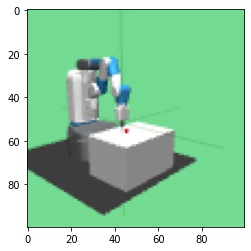

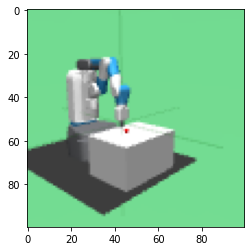

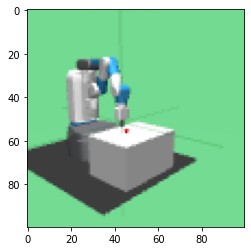

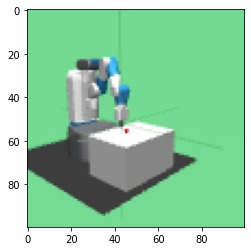

In [44]:
import matplotlib.pyplot as plt
for i, frame in enumerate(np.moveaxis(env._obs_from_buf()['frame_stack_3d'][0], 0, 1)):
    plt.figure(i)
    plt.clf()
    plt.imshow(np.moveaxis(frame, 0, -1))